# Training a Coarse-Grained Force Field with Embeddings from SchNet

In this tutorial we build upon the standard CGnet [1] architecture by additionally adding a SchNet [2] layer and, thereby, embedded properties of the coarse-grained beads. We again utilize the subsampled alanine dipeptide dataset, which should _not_ be used for research results.

If you haven't done the Training-A-Coarse-Grained-Force-Field tutorial, we recommend going through that notebook first, since we breeze through analogous calculations here.

## Imports, setup, and dataset

In [1]:
import numpy as np
import torch.nn as nn
import torch
import mdtraj as md

from torch.utils.data import DataLoader, RandomSampler
from torch.optim.lr_scheduler import MultiStepLR

from cgnet.feature import (MoleculeDataset, GeometryStatistics,
                           GeometryFeature, ShiftedSoftplus,
                           CGBeadEmbedding, SchnetFeature,
                           FeatureCombiner, LinearLayer)

from cgnet.network import (HarmonicLayer, CGnet, ForceLoss,
                           lipschitz_projection, Simulation)

from cgnet.molecule import CGMolecule

import matplotlib.pyplot as plt
%matplotlib inline

# We specify the cpu device here, but a gpu works too!
device = torch.device('cpu')

Load the data: if you want to run the notebook really quickly, we suggest using the second set of coordinates and forces for a meaningless result but quick execution.

In [19]:
coords = np.load('./data/ala2_coordinates.npy')
forces = np.load('./data/ala2_forces.npy')

# coords = np.load('./data/ala2_coordinates.npy')[::10]
# forces = np.load('./data/ala2_forces.npy')[::10]

print("Coordinates size: {}".format(coords.shape))
print("Force: {}".format(forces.shape))

Coordinates size: (1000, 5, 3)
Force: (1000, 5, 3)


Unlike the previous example, we not only need coordinates and forces, but also _embeddings_. Here we're going to go with the SchNet convention [2] of embedding the atomic number of the element corresponding to the bead. Since our beads are the backbone C-N-C-C-N, we embed the properties (6, 7, 6, 6, 7). We'll create the embeddings ourselves as follows:

In [20]:
embeddings = np.tile([6, 7, 6, 6, 7], [coords.shape[0], 1])
print("Embeddings size: {}".format(embeddings.shape))

Embeddings size: (1000, 5)


This time, we instantiate our `MoleculeDataset` with emeddings as well:

In [21]:
ala_data = MoleculeDataset(coords, forces, embeddings)
print("Dataset length: {}".format(len(ala_data)))

Dataset length: 1000


## Gathering statistics and making our GeometryFeature

Ultimately, our network is going to have a GeometryFeature, like before, except this time stacked with a SchnetFeature. So we still need to grab the statistics for our priors.

In [22]:
stats = GeometryStatistics(coords, backbone_inds='all')

bond_list, bond_keys = stats.get_prior_statistics(features='Bonds', as_list=True)
bond_indices = stats.return_indices('Bonds')

angle_list, angle_keys = stats.get_prior_statistics(features='Angles', as_list=True)
angle_indices = stats.return_indices('Angles')

print("We have {} backbone beads, {} bonds, and {} angles.".format(
                        coords.shape[1], len(bond_list), len(angle_list)))

We have 5 backbone beads, 4 bonds, and 3 angles.


In [23]:
all_stats, _ = stats.get_prior_statistics(as_list=True)
zscores, _ = stats.get_zscore_array()

In [24]:
n_beads = coords.shape[1]
geometry_feature = GeometryFeature(n_beads=n_beads,
                                   device=device)

## Specifying hyperparameters

We specify all the hyperparameters now, since we'll need some of them to build our `SchnetFeature`.

In [25]:
# hyperparameters

n_layers = 5
n_nodes = 128
activation = ShiftedSoftplus()
batch_size = 512
learning_rate = 3e-4
rate_decay = 0.3
lipschitz_strength = 4.0

# schnet-specific parameters
n_embeddings = 10
n_gaussians = 50
n_interaction_blocks = 5

num_epochs = 5

save_model = False
directory = '.' # to save model

# why are n_gaussians and n_interaction_blocks
# not hyperparams? 

## Create our SchnetFeature

We first need to make a `CGBeadEmbedding`, which we then pass to the `SchnetFeature`. We set `calculate_geometry` to `False` because we are going to be stacking this with a `GeometryFeature`, which handles the geometry stuff for us.

In [26]:
embedding_layer = CGBeadEmbedding(n_embeddings = n_embeddings,
                                  embedding_dim = n_nodes)

schnet_feature = SchnetFeature(feature_size = n_nodes,
                               embedding_layer = embedding_layer,
                               n_interaction_blocks = n_interaction_blocks,
                               calculate_geometry = False,
                               n_beads = n_beads,
                               neighbor_cutoff = None,
                               n_gaussians = n_gaussians,
                               device = device)

## Combine Geometry and SchnetFeatures

We use the `FeatureCombiner` to stack our `GeometryFeature` and our `SchnetFeature`. We just need to tell our `FeatureCombiner` which integer indices correspond to distance features. The `FeatureCombiner` is ultimately the feature we will feed into our `CGnet`.

In [27]:
distance_feature_indices = stats.return_indices('Distances')

layer_list = [geometry_feature, schnet_feature]

feature_combiner = FeatureCombiner(layer_list,
                    distance_indices=distance_feature_indices)

## Assemble the CGnet and training tools

Assemble the layers and priors, and then feed those and the `FeatureCombiner` into a `CGnet`.

In [28]:
layers = LinearLayer(n_nodes,
                     n_nodes,
                     activation=activation)

for _ in range(n_layers - 1):
    layers += LinearLayer(n_nodes,
                          n_nodes,
                          activation=activation)

# The last layer produces a single value
layers += LinearLayer(n_nodes, 1, activation=None)

In [29]:
priors  = [HarmonicLayer(bond_indices, bond_list)]
priors += [HarmonicLayer(angle_indices, angle_list)]

In [30]:
ala2_net = CGnet(layers, ForceLoss(),
                 feature=feature_combiner,
                 priors=priors).to(device)

In [31]:
trainloader = DataLoader(ala_data, sampler=RandomSampler(ala_data),
                         batch_size=batch_size)
optimizer = torch.optim.Adam(ala2_net.parameters(),
                             lr=learning_rate)
scheduler = MultiStepLR(optimizer,milestones=[10,20,30,40,50],
                        gamma=rate_decay)
epochal_train_losses = []
epochal_test_losses  = []
verbose = True

# printout settings
batch_freq = 500
epoch_freq = 1

## Train the model!

Note that we do not use a test set, so this is just for demonstration.

In [32]:
for epoch in range(1, num_epochs+1):
    train_loss = 0.00
    test_loss = 0.00
    n = 0
    for num, batch in enumerate(trainloader):
        optimizer.zero_grad()
        coord, force, embedding_property = batch

        
        energy, pred_force = ala2_net.forward(coord,
                                embedding_property=embedding_property)
        batch_loss = ala2_net.criterion(pred_force, force)
        batch_loss.backward()
        optimizer.step()
        
        # perform L2 lipschitz check and projection
        lipschitz_projection(ala2_net, strength=lipschitz_strength)
        if verbose:
            if (num+1) % batch_freq == 0:
                print(
                    "Batch: {: <5} Train: {: <20} Test: {: <20}".format(
                        num+1, batch_loss, test_loss)
                )
        train_loss += batch_loss.detach().cpu()
        n += 1

    train_loss /= n
    if verbose:
        if epoch % epoch_freq == 0:
            print(
                "Epoch: {: <5} Train: {: <20} Test: {: <20}".format(
    epoch, train_loss, test_loss))
    epochal_train_losses.append(train_loss)
    scheduler.step()
    
if save_model:
    torch.save(ala2_net,"{}/ala2_cgschnet.pt".format(directory))

Epoch: 1     Train: 377.2593078613281    Test: 0.0                 
Epoch: 2     Train: 377.20263671875      Test: 0.0                 
Epoch: 3     Train: 376.93231201171875   Test: 0.0                 
Epoch: 4     Train: 376.9790344238281    Test: 0.0                 
Epoch: 5     Train: 376.9073181152344    Test: 0.0                 


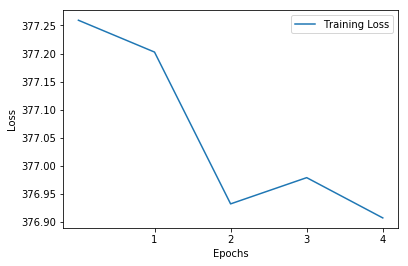

In [33]:
fig = plt.figure()
plt.plot(np.arange(0,len(epochal_train_losses),1),
         epochal_train_losses, label='Training Loss')
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.xticks(np.arange(1,5))
plt.ylabel("Loss")
plt.show()

## Simulate the system

To simulate a system with a `SchnetFeature`, we need to provide the `Simulation` with embeddings.

Simulations with `SchnetFeature`s tend to be _slow_. If you haven't switched your device to a GPU, we recommend the second set of parameters for a meaningless result but quickly executable code.

In [54]:
n_sims = 1000
n_timesteps = 1000
save_interval = 10

# n_sims = 10
# n_timesteps = 1000
# save_interval = 1

In [56]:
initial_coords = np.concatenate([coords[i].reshape(-1,5,3)
                                 for i in np.arange(0, coords.shape[0],
                                                    coords.shape[0]//n_sims)],
                                                    axis=0)
initial_coords = torch.tensor(initial_coords, requires_grad=True)
sim_embeddings = torch.tensor(embeddings[:n_sims])

print("Produced {} initial coordinates.".format(len(initial_coords)))

sim = Simulation(ala2_net, initial_coords, sim_embeddings, length=n_timesteps,
                 save_interval=save_interval, beta=stats.beta,
                 verbose=True, save_potential=True)

traj = sim.simulate()

Tue Oct  8 20:07:05 2019
Produced 10 initial coordinates.
Generating 10 simulations of length 1000 at 1-step intervals
10% finished
20% finished
30% finished
40% finished
50% finished
60% finished
70% finished
80% finished
90% finished
100% finished.
Tue Oct  8 20:07:28 2019


## Analyze the simulation output

Here, we just copy the code from the previous tutorial to show the same example visualization.

In [57]:
names = ['C', 'N', 'CA', 'C', 'N']
resseq = [1, 2, 2, 2, 3]
resmap = {1: 'ACE', 2: 'ALA', 3: 'NME'}

ala2_cg = CGMolecule(names=names, resseq=resseq, resmap=resmap,
                          bonds='standard')

ala2_traj = ala2_cg.make_trajectory(coords)
ala2_simulated_traj = ala2_cg.make_trajectory(np.concatenate(traj, axis=0))

_, phi = md.compute_phi(ala2_traj)
_, psi = md.compute_psi(ala2_traj)

_, sim_phi = md.compute_phi(ala2_simulated_traj)
_, sim_psi = md.compute_psi(ala2_simulated_traj)

pot, _ = ala2_net.forward(torch.tensor(coords, requires_grad=True),
                          torch.tensor(embeddings))
pot = pot.detach().numpy()
pot = pot - np.min(pot)

sim_pot = np.concatenate(sim.simulated_potential, axis=0)
sim_pot = sim_pot - np.min(sim_pot)

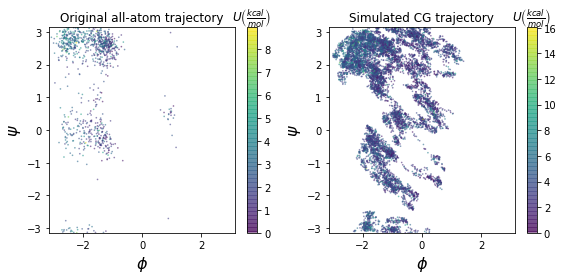

In [58]:
plt.subplots(figsize=(8,4))

plt.subplot(1,2,1)
plt.scatter(phi.reshape(-1), psi.reshape(-1),
            c=pot.flatten(),
            cmap=plt.get_cmap("viridis"),alpha=0.5,s=0.5)
plt.xlabel(r'$\phi$',fontsize=16)
plt.ylabel(r'$\psi$',fontsize=16)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.title(r'Original all-atom trajectory')
clb=plt.colorbar()
clb.ax.set_title(r'$U\left(\frac{kcal}{mol}\right)$')

plt.subplot(1,2,2)
plt.scatter(sim_phi.reshape(-1), sim_psi.reshape(-1),
            c=sim_pot.flatten(),
            cmap=plt.get_cmap("viridis"),alpha=0.5,s=0.5)
plt.xlabel(r'$\phi$',fontsize=16)
plt.ylabel(r'$\psi$',fontsize=16)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.title('Simulated CG trajectory')
clb=plt.colorbar()
clb.ax.set_title(r'$U\left(\frac{kcal}{mol}\right)$')

plt.tight_layout()

In [59]:
def plot_ramachandran(phi, psi, bins=60, cmap=plt.cm.magma):
    edges = np.array([[-np.pi, np.pi], [-np.pi, np.pi]])
    counts, _, _ = np.histogram2d(psi.reshape(-1),
                                  phi.reshape(-1),
                                  bins=bins,
                                  range=edges)
    populations = counts / np.sum(counts)
    
    # compute energies for only non-zero entries
    # 1/beta is approximately 0.6 kcal/mol at 300 K
    energies = -0.6*np.log(populations,
                           out=np.zeros_like(populations),
                           where=(populations > 0))
    
    # make the lowest energy slightly above zero
    energies = np.where(energies,
                        energies-np.min(energies[np.nonzero(energies)]) + 1e-6,
                        0)
    
    # mask the zero values from the colormap
    zvals_masked = np.ma.masked_where(energies == 0, energies)

    cmap.set_bad(color='white')
    img = plt.imshow(zvals_masked, interpolation='nearest', cmap = cmap)
    plt.gca().invert_yaxis()
    
    plt.xticks([-0.5, bins/2, bins], 
               [r'$-\pi$', r'$0$', r'$\pi$'])

    plt.yticks([-0.5, bins/2, bins],
               [r'$-\pi$', r'$0$', r'$\pi$'])
    
    plt.xlabel(r'$\phi$',fontsize=16)
    plt.ylabel(r'$\psi$',fontsize=16)
    
    cb=plt.colorbar()
    cb.ax.set_title(r'$\tilde{F}\left(\frac{kcal}{mol}\right)$')

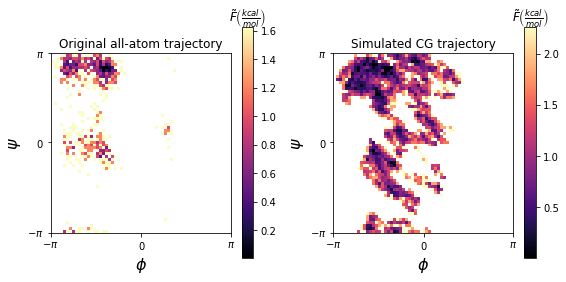

In [60]:
fig, axes = plt.subplots(figsize=(8,4))

plt.subplot(1,2,1)
plot_ramachandran(phi, psi)
plt.title('Original all-atom trajectory')

plt.subplot(1,2,2)
plot_ramachandran(sim_phi, sim_psi)
plt.title('Simulated CG trajectory')

plt.tight_layout()

#### *References*

[1] Wang, J., Olsson, S., Wehmeyer, C., Pérez, A., Charron, N. E., de Fabritiis, G., Noé, F., and Clementi, C. (2019). Machine Learning of Coarse-Grained Molecular Dynamics Force Fields. _ACS Central Science._ https://doi.org/10.1021/acscentsci.8b00913

[2] Schütt, K. T., Sauceda, H. E., Kindermans, P.-J., Tkatchenko, A., and Müller, K.-R. (2018). SchNet - A deep learning architecture for molecules and materials. _J. Chem. Phys._ https://doi.org/10.1063/1.5019779